In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
filepath = 'https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/cantons/'

In [27]:
data = pd.read_csv(filepath + 'Final_vhc.csv')

In [28]:
data.rename(columns={"% EV vs Fossil":"EVshare", 'Electricity':'EV', 'Fossil': 'ICE'}, inplace=True)

In [29]:
df = data.copy()

In [31]:
# Replace missing pollution values in 2015 with the mean of 2014 and 2016 for the same canton
def fill_missing_pollution(df):
    for canton in df['Canton'].unique():
        mask_2015 = (df['year'] == 2015) & (df['Canton'] == canton)
        mask_2014 = (df['year'] == 2014) & (df['Canton'] == canton)
        mask_2016 = (df['year'] == 2016) & (df['Canton'] == canton)
        
        if mask_2015.any():
            mean_pollution = df.loc[mask_2014, 'pollution'].mean() + df.loc[mask_2016, 'pollution'].mean()
            mean_pollution /= 2
            df.loc[mask_2015, 'pollution'] = df.loc[mask_2015, 'pollution'].fillna(mean_pollution)

fill_missing_pollution(df)

In [32]:
# Replace missing pollution values in 2015 with the mean of 2014 and 2016 for the same canton
def fill_missing_pollution(df):
    for canton in df['Canton'].unique():
        mask_2017 = (df['year'] == 2017) & (df['Canton'] == canton)
        mask_2016 = (df['year'] == 2014) & (df['Canton'] == canton)
        mask_2018 = (df['year'] == 2018) & (df['Canton'] == canton)
        
        if mask_2017.any():
            mean_pollution = df.loc[mask_2016, 'pollution'].mean() + df.loc[mask_2018, 'pollution'].mean()
            mean_pollution /= 2
            df.loc[mask_2017, 'pollution'] = df.loc[mask_2017, 'pollution'].fillna(mean_pollution)

fill_missing_pollution(df)

In [34]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df[(df['year'] >=2014) & (df['year'] <= 2023)]

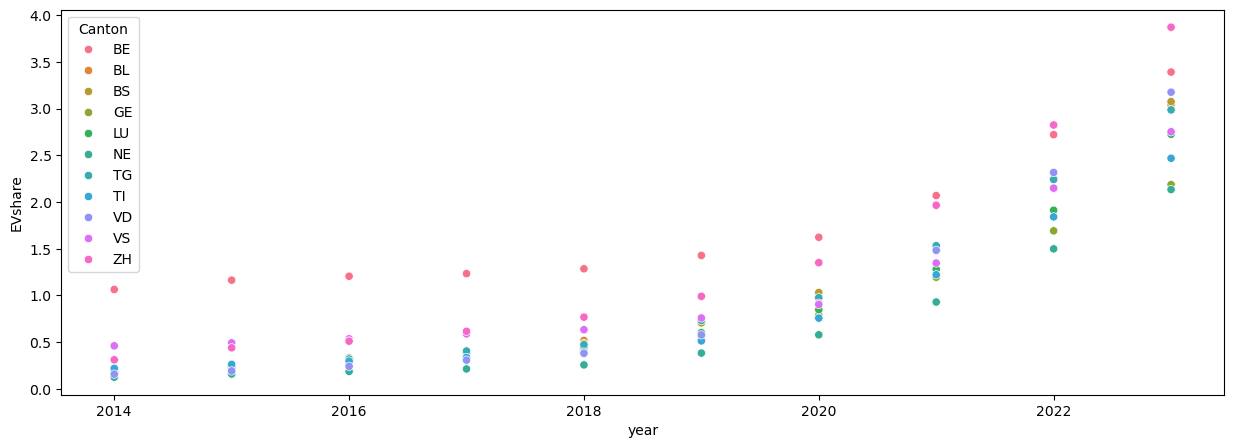

In [37]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df, x='year', y='EVshare', hue='Canton')
#plt.scatter(data['year'], data['Fossil'], color='red')
plt.show()

# Analysis

In [39]:
df.isna().sum()

year         0
GDP          0
Name         0
pop          0
pollution    0
temp         0
precip       0
Canton       0
EVshare      0
EV           0
ICE          0
dtype: int64

MSE: 158.57946949331378
MAE: 6.871006226439607
R² Score: 0.07133010465816303


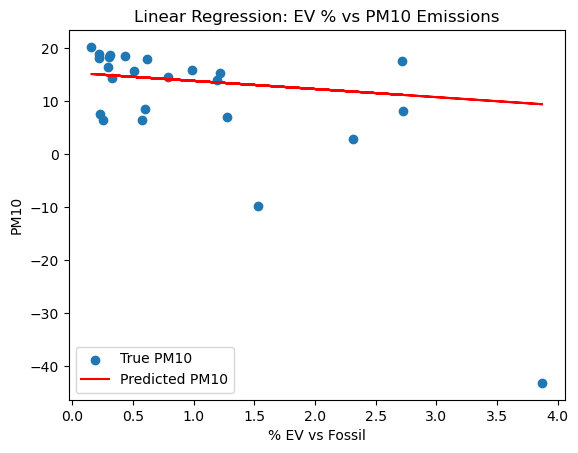

In [41]:
# Define X and y
X = df[['EVshare']]
y = df[['pollution']]

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Optional: visualize results
import matplotlib.pyplot as plt
plt.scatter(X_test, y_test, label='True PM10')
plt.plot(X_test, y_pred, color='red', label='Predicted PM10')
plt.xlabel('% EV vs Fossil')
plt.ylabel('PM10')
plt.title('Linear Regression: EV % vs PM10 Emissions')
plt.legend()
plt.show()

MSE: 146.92942448460875
MAE: 6.825311838654694
R² Score: 0.1395548635978312


c:\Users\simon\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


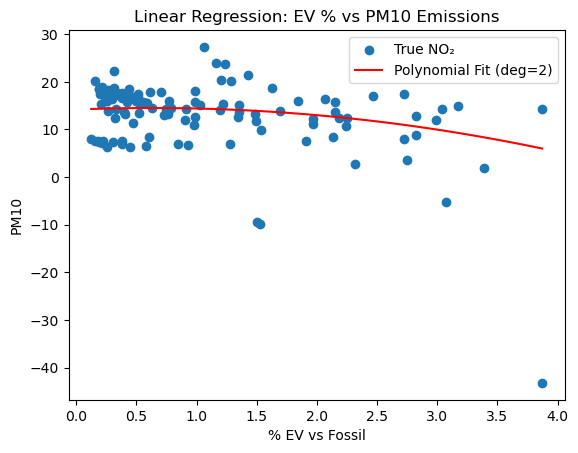

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 2. Define X and y
X = df[['EVshare']]
y = df[['pollution']]

# 3. Transform features into polynomial (degree = 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
import numpy as np
x_range = np.linspace(X['EVshare'].min(), X['EVshare'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='True NO₂')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('% EV vs Fossil')
plt.ylabel('PM10')
plt.title('Linear Regression: EV % vs PM10 Emissions')
plt.legend()
plt.show()


In [45]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Use full data
X = df[['EVshare']]
y = df[['pollution']]

# Create polynomial regression pipeline (degree 2)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Define 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation for MSE
cv_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Convert negative MSE to positive
mse_scores = -cv_mse_scores

# Print results
print("MSE scores (per fold):", mse_scores)
print("Average MSE:", np.mean(mse_scores))
print("R² scores (per fold):", cv_r2_scores)
print("Average R²:", np.mean(cv_r2_scores))

MSE scores (per fold): [ 47.01409409  40.15296402  25.63226499  25.4217628  158.15380068]
Average MSE: 59.27497731595129
R² scores (per fold): [-1.43486236 -0.09066283 -0.42327594  0.22623847  0.0953826 ]
Average R²: -0.3254360125738299


In [47]:
df.columns

Index(['year', 'GDP', 'Name', 'pop', 'pollution', 'temp', 'precip', 'Canton',
       'EVshare', 'EV', 'ICE'],
      dtype='object')

In [48]:
# Define features and target
X = df[['EVshare', 'pop', 'temp', 'precip', 'GDP']]
y = df[['pollution']]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 163.84646536344516
MAE: 6.29148277357002
R² Score: 0.04048562952459589


In [49]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['EVshare', 'pop', 'temp', 'precip', 'GDP']]
X_const = sm.add_constant(X)
y = df['pollution']

model = sm.OLS(y, X_const).fit()
print(model.summary())

vif_df = pd.DataFrame()
vif_df['Variable'] = X_const.columns
vif_df['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_df)

                            OLS Regression Results                            
Dep. Variable:              pollution   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     5.507
Date:                Tue, 13 May 2025   Prob (F-statistic):           0.000143
Time:                        16:10:25   Log-Likelihood:                -395.78
No. Observations:                 118   AIC:                             803.6
Df Residuals:                     112   BIC:                             820.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4781     11.405      0.568      0.5

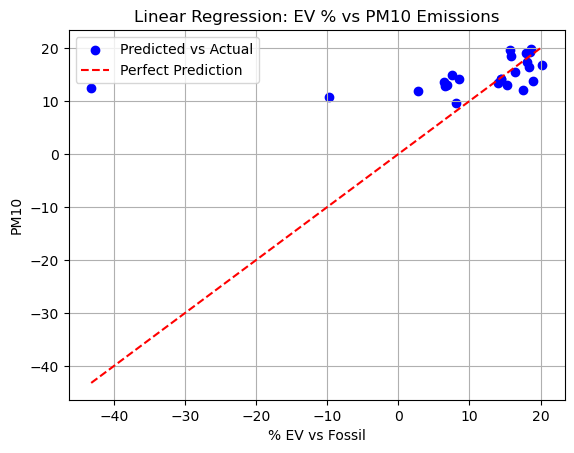

In [50]:
# Flatten y_test and y_pred for plotting
y_test_flat = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

plt.scatter(y_test_flat, y_pred_flat, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('% EV vs Fossil')
plt.ylabel('PM10')
plt.title('Linear Regression: EV % vs PM10 Emissions')
plt.legend()
plt.grid(True)
plt.show()

     


c:\Users\simon\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


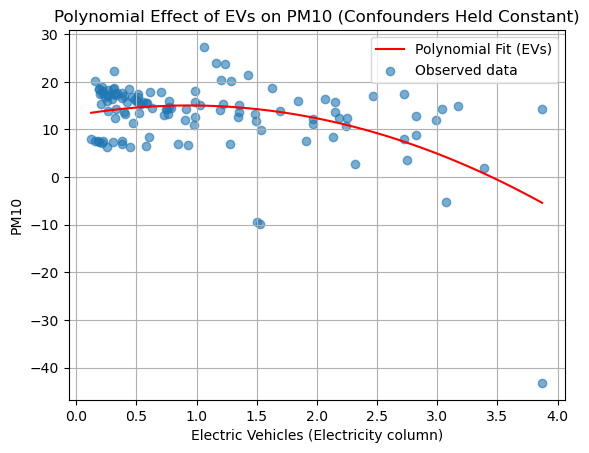

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Step 1: Generate EV range
ev_range = np.linspace(df['EVshare'].min(), df['EVshare'].max(), 100)

# Step 2: Create base DataFrame with other variables held constant at their means
mean_vals = df[['EVshare', 'pop', 'temp', 'precip', 'GDP']].mean()
X_curve = pd.DataFrame({
    'Electricity': ev_range,
    'population': mean_vals['pop'],
    'temp': mean_vals['temp'],
    'precip': mean_vals['precip'],
    'gdp': mean_vals['GDP']
})

# Step 3: Create polynomial features for 'Electricity' only
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df[['EVshare']])

# Fit polynomial model using EV only (other vars constant)
poly_model = LinearRegression()
poly_model.fit(poly.fit_transform(df[['EVshare']]), df['pollution'])

# Step 4: Predict using EV curve
ev_range_poly = poly.transform(ev_range.reshape(-1, 1))
y_curve_pred = poly_model.predict(ev_range_poly)

# Step 5: Plot
plt.plot(ev_range, y_curve_pred, color='red', label='Polynomial Fit (EVs)')
plt.scatter(df['EVshare'], df['pollution'], alpha=0.6, label='Observed data')
plt.xlabel('Electric Vehicles (Electricity column)')
plt.ylabel('PM10')
plt.title('Polynomial Effect of EVs on PM10 (Confounders Held Constant)')
plt.legend()
plt.grid(True)
plt.show()


# Canton de Vaud

In [53]:
df_vaud = df[df['Canton'] == 'VD']

MSE: 46.78573588048478
MAE: 5.624993688697846
R² Score: 0.043275437437746755


c:\Users\simon\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


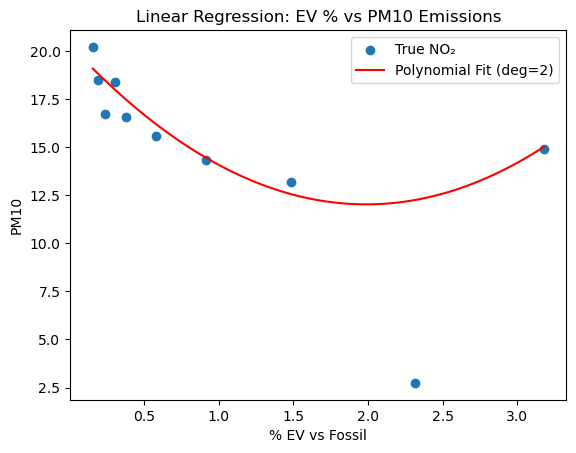

In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 2. Define X and y
X = df_vaud[['EVshare']]
y = df_vaud[['pollution']]

# 3. Transform features into polynomial (degree = 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
import numpy as np
x_range = np.linspace(X['EVshare'].min(), X['EVshare'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='True NO₂')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('% EV vs Fossil')
plt.ylabel('PM10')
plt.title('Linear Regression: EV % vs PM10 Emissions')
plt.legend()
plt.show()



In [58]:
# Define features and target
X = df[['EVshare', 'pop', 'temp', 'precip', 'GDP']]
y = df[['pollution']]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 163.84646536344516
MAE: 6.29148277357002
R² Score: 0.04048562952459589


In [60]:
# Define features and target
X = df[['EVshare', 'pop', 'temp', 'precip', 'GDP']]
y = df[['pollution']]

# Train-test split
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 158.64048425865147
MAE: 6.838149248855835
R² Score: 0.07097279121827393


In [56]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_vaud[['EVshare', 'pop', 'temp', 'precip', 'GDP']]
X_const = sm.add_constant(X)
y = df_vaud['pollution']

model = sm.OLS(y, X_const).fit()
print(model.summary())

vif_df = pd.DataFrame()
vif_df['Variable'] = X_const.columns
vif_df['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_df)

                            OLS Regression Results                            
Dep. Variable:              pollution   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     1.093
Date:                Tue, 13 May 2025   Prob (F-statistic):              0.479
Time:                        16:20:43   Log-Likelihood:                -25.117
No. Observations:                  10   AIC:                             62.23
Df Residuals:                       4   BIC:                             64.05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.1044    126.280      0.611      0.5

c:\Users\simon\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
